In [76]:
#librairies utilisées
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

Le fichier HEART DISEASE contient des informations et des résultats médicaux concernant des patients. La variable TARGET indique la présence (1) ou non (0) d'une maladie cardiage chez le patient.
Le principal objectif est de prédire la présence ou non d'une maladie cardiaque chez un patient.

EXPLORATION DU JEU DE DONNEES

In [77]:
#lecture du fichier
df=pd.read_csv("heart_disease.csv.csv", index_col=0, sep=',')
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
ID,,,,,,,,,,,,,,
1012,63,Male,3,145.0,233.0,1,0,150.0,0.0,2.3,0,0.0,1,1.0
1264,37,Male,2,130.0,250.0,0,1,187.0,0.0,3.5,0,0.0,2,1.0
1217,41,Female,1,130.0,204.0,0,0,NaN,0.0,1.4,2,0.0,2,1.0
1300,56,Male,1,120.0,236.0,0,1,178.0,0.0,0.8,2,0.0,2,1.0
1049,57,Female,0,120.0,354.0,0,1,163.0,1.0,0.6,2,0.0,2,1.0


In [3]:
#Info du fichier
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 1012 to 1126
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    int64  
 3   trestbps  302 non-null    float64
 4   chol      300 non-null    float64
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        300 non-null    float64
 12  thal      303 non-null    int64  
 13  target    300 non-null    float64
dtypes: float64(7), int64(6), object(1)
memory usage: 35.5+ KB


In [4]:
#présence de duplicata et/ou valeurs manquantes
print('Duplicata : ', df.duplicated().sum())
print('Valeurs manquantes:', df.isna().sum())
print(df.shape)

Duplicata :  1
Valeurs manquantes: age         0
sex         0
cp          0
trestbps    1
chol        3
fbs         0
restecg     0
thalach     6
exang       6
oldpeak     0
slope       0
ca          3
thal        0
target      3
dtype: int64
(303, 14)


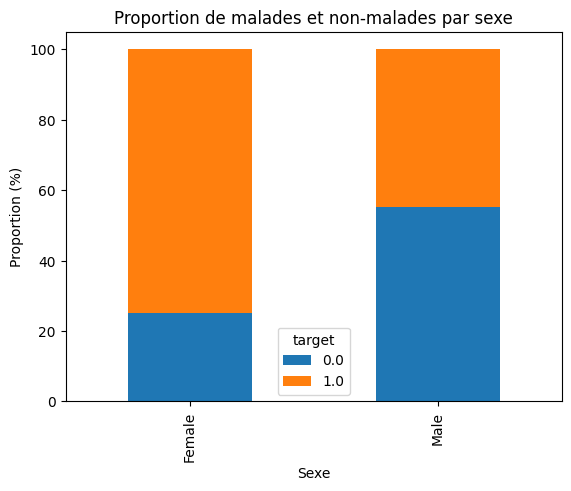

In [5]:
#Proportion de malades et non malades selon le sexe des patients :Disparité de santé.
proportion=df.groupby('sex')['target'].value_counts(normalize=True).mul(100).rename('Proportion')

proportion.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Sexe')
plt.ylabel('Proportion (%)')
plt.title('Proportion de malades et non-malades par sexe')
plt.show()

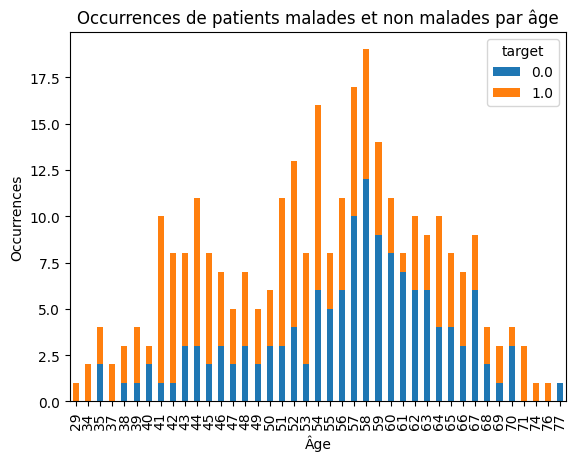

In [ ]:
#Occurences de patients malades et non malades selon l'âge : tendance générale selon certaine tranche d'age :
result = df.groupby(['age', 'target']).size().unstack().fillna(0)
result.plot(kind='bar', stacked=True)
plt.xlabel('Âge')
plt.ylabel('Occurrences')
plt.title('Occurrences de patients malades et non malades par âge')
plt.show()

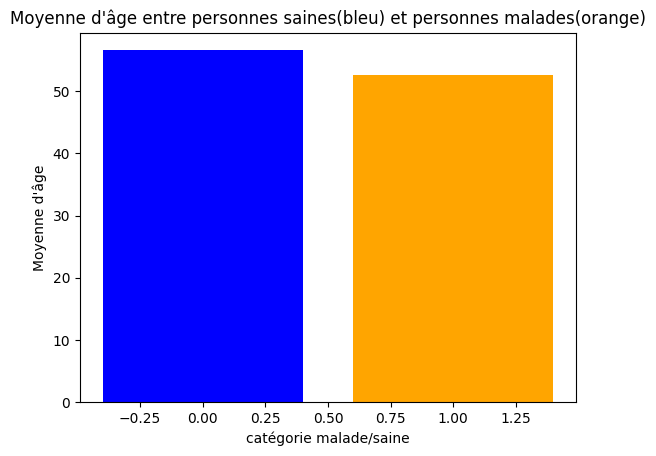

In [ ]:
#moyenne d'age entre personnes saines et personnes malades : L'âge est-il un facteur de risque ?
moy=df.groupby('target')['age'].mean()
plt.bar(moy.index, moy, color=['blue', 'orange'])
plt.title("Moyenne d'âge entre personnes saines(bleu) et personnes malades(orange)")
plt.xlabel("catégorie malade/saine")
plt.ylabel("Moyenne d'âge")
plt.show()

PIPELINE DE PREPARATION DU JEU DE DONNEES

In [6]:
#Boucle for pour déterminer les valeurs uniques sur les colonnes numériques
for col in df.select_dtypes(include=['int', 'float']).columns:
    print(df[col].unique())

[63 37 41 56 57 44 52 54 48 49 64 58 50 66 43 69 59 42 61 40 71 51 65 53
 46 45 39 47 62 34 35 29 55 60 67 68 74 76 70 38 77]
[3 2 1 0]
[145. 130. 120. 140. 172. 150. 110. 135. 160. 105. 125. 142. 155. 104.
 138. 128. 108. 134. 122. 115. 118. 100. 124.  94. 112. 102. 152. 101.
 132. 148. 178. 129. 180. 136. 126. 106. 156. 170. 146. 117. 200. 165.
 174. 192. 144. 123. 154. 114. 164.  nan]
[233. 250. 204. 236. 354. 192. 294. 263. 199. 168. 239. 275. 266. 211.
 283. 219. 340. 226. 247. 234. 243. 302. 212. 175. 417. 197. 198. 177.
 273. 213. 304. 232. 269. 360. 308. 245. 208. 264. 321. 325. 235. 257.
 216. 256. 231. 141. 252. 201. 222. 260. 182. 303. 265. 309. 186. 203.
 183. 220. 209. 258. 227. 261. 221. 205.  nan 318. 298. 564. 277. 214.
 248. 255. 207. 223. 288. 160. 394. 315. 246. 244. 270. 195. 240. 196.
 254. 126. 313. 262. 215. 193. 271. 268. 267. 210. 295. 306. 178. 242.
 180. 228. 149. 278. 253. 342. 157. 286. 229. 284. 224. 206. 167. 230.
 335. 276. 353. 225. 330. 290. 172. 305. 

In [78]:
#Verification des types et quelques changements dans le dataframe :
#Colonne sex : remplacement par les valeurs binaires : Male : 0 et Female : 1
df['sex']=df['sex'].replace(to_replace=['Male', 'Female'], value=[0,1])
df['sex'].info

<bound method Series.info of ID
1012    0
1264    0
1217    1
1300    0
1049    1
       ..
1034    1
1194    0
1010    0
1225    0
1126    1
Name: sex, Length: 303, dtype: int64>

In [79]:
#Recherche et suppression des duplicas dans toutes les colonnes du dataframe
df = df.drop_duplicates()

#

# Définition des colonnes spécifiques
columns_with_missing_values = ['ca', 'exang', 'trestbps','chol', 'thalach']

#Liste des colonnes catégorielles
categorical_columns = ['cp', 'restecg', 'slope', 'thal', 'ca']

# Liste des colonnes continues
continuous_columns = ['trestbps', 'chol','thalach', 'age', 'oldpeak' ]

# Liste des colonnes binaires
binary_columns = ['exang', 'fbs', 'target', 'sex']

# Création du transformateur pour les colonnes catégorielles
categorical_encoder = OneHotEncoder(sparse=False, drop='first')

# Création du transformateur pour les colonnes continues
continuous_imputer = SimpleImputer(strategy='median')

# Création du transformateur pour les colonnes binaires
binary_imputer = SimpleImputer(strategy='most_frequent')

# Création du transformateur pour toutes les colonnes
column_transformer = ColumnTransformer([
    ('imputer_median', continuous_imputer, continuous_columns),
    ('imputer_mode', binary_imputer, binary_columns),
    ('encoder', categorical_encoder, categorical_columns)])

# Création de la pipeline de prétraitement des données
data_pipeline = Pipeline([
    ('drop_duplicates', FunctionTransformer(lambda x: pd.DataFrame(x).drop_duplicates(subset=pd.DataFrame(x).columns))),
    ('drop_na_target', FunctionTransformer(lambda x: pd.DataFrame(x).dropna(subset=['target']))),
    ('impute', column_transformer),
    ('recoding', FunctionTransformer(lambda x: pd.DataFrame(x).replace({'thalach': {19500.: 195.}}))),
    ('scaler', StandardScaler())])

# Application de la pipeline de prétraitement des données sur le dataframe
df_processed = data_pipeline.fit_transform(df)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


 PIPELINE -MODELISATION

In [59]:
#Séparation du jeu de données :
X = df_processed[:, :-1]
y = df_processed[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Conversion en DataFrames pandas
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [47]:
print(X_train, X_test, y_train, y_test)

           0         1         2         3         4         5        6   \
0    2.179670  0.797282 -0.049556  0.505262 -0.719549 -0.692963 -0.42091   
1   -0.663543  0.218368 -0.060295 -0.046503 -0.547708 -0.692963 -0.42091   
2   -0.663543  0.662202 -0.099672  0.836321  0.311498 -0.692963 -0.42091   
3    1.611027  2.186677 -0.056715  1.167380 -0.204025 -0.692963 -0.42091   
4    1.042385 -0.399141 -0.089828  1.277733  1.342545 -0.692963 -0.42091   
..        ...       ...       ...       ...       ...       ...      ...   
204 -0.208629 -0.100035 -0.074614  0.394909  0.998862  1.443078 -0.42091   
205  0.473742  0.276259 -0.025393 -0.377562 -0.891390  1.443078 -0.42091   
206 -0.663543 -0.051793 -0.046871 -0.487915  0.053736 -0.692963 -0.42091   
207 -1.232186  0.546419 -0.086248 -0.818974 -0.032184  1.443078 -0.42091   
208 -0.151765 -0.978056 -0.045976 -0.487915 -0.891390 -0.692963 -0.42091   

           7         8         9   ...        12        13        14  \
0   -1.087420 -

In [50]:
# Création de la pipeline
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())])

pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier())])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())])

pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True))])

pipeline_nb = Pipeline([
    ('classifier', GaussianNB())])

pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(max_iter=500))])

# Liste des pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svm, pipeline_nb, pipeline_mlp]

# Conversion des variables cibles en binaires
y_train_binary = y_train.astype(int).values.ravel()
y_test_binary = y_test.astype(int).values.ravel()

# Exécution
for pipeline in pipelines:
    # Entraînement du modèle sur les données d'entraînement
    pipeline.fit(X_train, y_train_binary)

    # Prédiction sur les données de test
    y_pred_test = pipeline.predict(X_test)

    # Prédiction sur les données d'entraînement
    y_pred_train = pipeline.predict(X_train)

    # Calcul du score d'exactitude sur les données d'entraînement et de test
    accuracy_train = accuracy_score(y_train_binary, y_pred_train)
    accuracy_test = accuracy_score(y_test_binary, y_pred_test)

    # Obtention du nom du modèle de classification
    classifier_name = pipeline.named_steps['classifier'].__class__.__name__

    print(f"{classifier_name}")
    print(f"Score sur les données d'entraînement : {accuracy_train}")
    print(f"Score sur les données de test : {accuracy_test}")
    print()

LogisticRegression
Score sur les données d'entraînement : 1.0
Score sur les données de test : 0.9888888888888889

DecisionTreeClassifier
Score sur les données d'entraînement : 1.0
Score sur les données de test : 0.9888888888888889

RandomForestClassifier
Score sur les données d'entraînement : 1.0
Score sur les données de test : 0.9888888888888889

SVC
Score sur les données d'entraînement : 0.9904306220095693
Score sur les données de test : 0.9888888888888889

GaussianNB
Score sur les données d'entraînement : 0.9617224880382775
Score sur les données de test : 0.9666666666666667

MLPClassifier
Score sur les données d'entraînement : 1.0
Score sur les données de test : 0.9888888888888889



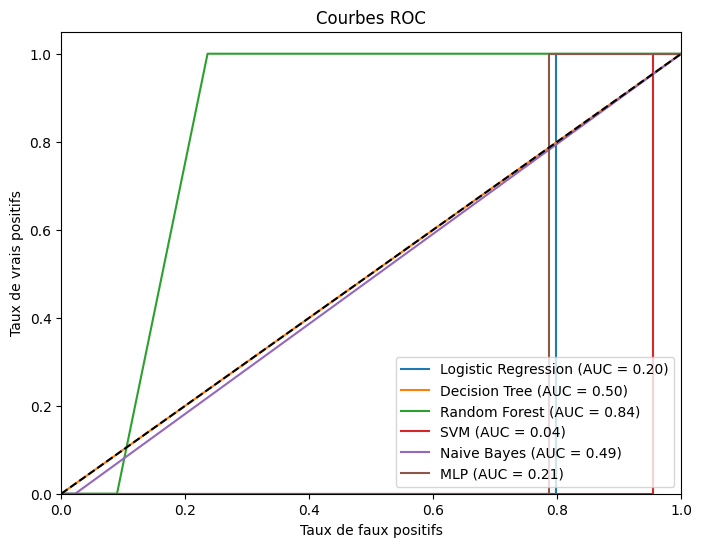

In [51]:
#Evaluation graphique des performances de chaque modèle en terme de spécificité (taux de faux positifs) et de sensibilité (taux de vrais positifs)
# Liste des noms des modèles
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Naive Bayes', 'MLP']

# Liste des modèles
models = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svm, pipeline_nb, pipeline_mlp]

# Courbes ROC (Receiver Operating Characteristic) et calculer l'Aire sous la courbe (AUC) pour chaque modèle
plt.figure(figsize=(8, 6))
for model, name in zip(models, model_names):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba,  pos_label=9)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC')
plt.legend(loc='lower right')
plt.show()